### Install various pretrained models packages

##### Note: Turn on Internet on kaggle kernel

In [34]:
!pip install timm                   # - https://github.com/rwightman/pytorch-image-models
!pip install efficientnet_pytorch   # - https://github.com/lukemelas/EfficientNet-PyTorch
!pip install pretrainedmodels       # - https://github.com/Cadene/pretrained-models.pytorch
!pip install torchtoolbox
!pip install torchviz

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=e8c13332182703a15378a15e34ed2f41562a93f22f999eafea98eebed0b5a473
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


### Dependencies

In [35]:
import os
import gc
gc.enable()
import time

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import torchtoolbox
from torchtoolbox.tools import summary
from torchviz import make_dot

from sklearn.metrics import roc_auc_score

import timm
import pretrainedmodels
import efficientnet_pytorch

In [36]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)


def seed_everything(seed=2020):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print("Seeding completed..")
seed_everything()

Seeding completed..


### Load CSV Dataset

In [37]:
# train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
# test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
# sample = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')

### Model 1

In [38]:
#This one is working but the model is too big to download in kaggle
class SEResnext50_32x4d(nn.Module):
    def __init__(self):
        super(SEResnext50_32x4d, self).__init__()
        self.arch = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained="imagenet")

        # dont need to do this if pretrained='imagenet' is specified, this snippet is required 
        # when you have set pretrained = None and have already stored the weight locally
        # self.arch.load_state_dict(torch.load("C:/Users/tushar.sharma/Desktop/SIIM-Kaggle/resnet18-5c106cde.pth"))

        self.arch.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.arch.last_linear = nn.Linear(in_features=2048, out_features=1)
    
    def forward(self, image):
        output = self.arch(image)
        return output

In [42]:
model = SEResnext50_32x4d()
summary(model, torch.rand(1,3,512,512))

--------------------------------------------------------------------------------
        Layer (type)               Output Shape          Params    FLOPs(M+A) #
            Conv2d-1          [1, 64, 256, 256]            9408      1228931072
       BatchNorm2d-2          [1, 64, 256, 256]             256         8388608
              ReLU-3          [1, 64, 256, 256]               0               0
         MaxPool2d-4          [1, 64, 128, 128]               0               0
            Conv2d-5         [1, 128, 128, 128]            8192       266338304
       BatchNorm2d-6         [1, 128, 128, 128]             512         4194304
              ReLU-7         [1, 128, 128, 128]               0               0
            Conv2d-8         [1, 128, 128, 128]            4608       150929408
       BatchNorm2d-9         [1, 128, 128, 128]             512         4194304
             ReLU-10         [1, 128, 128, 128]               0               0
           Conv2d-11         [1, 256, 1

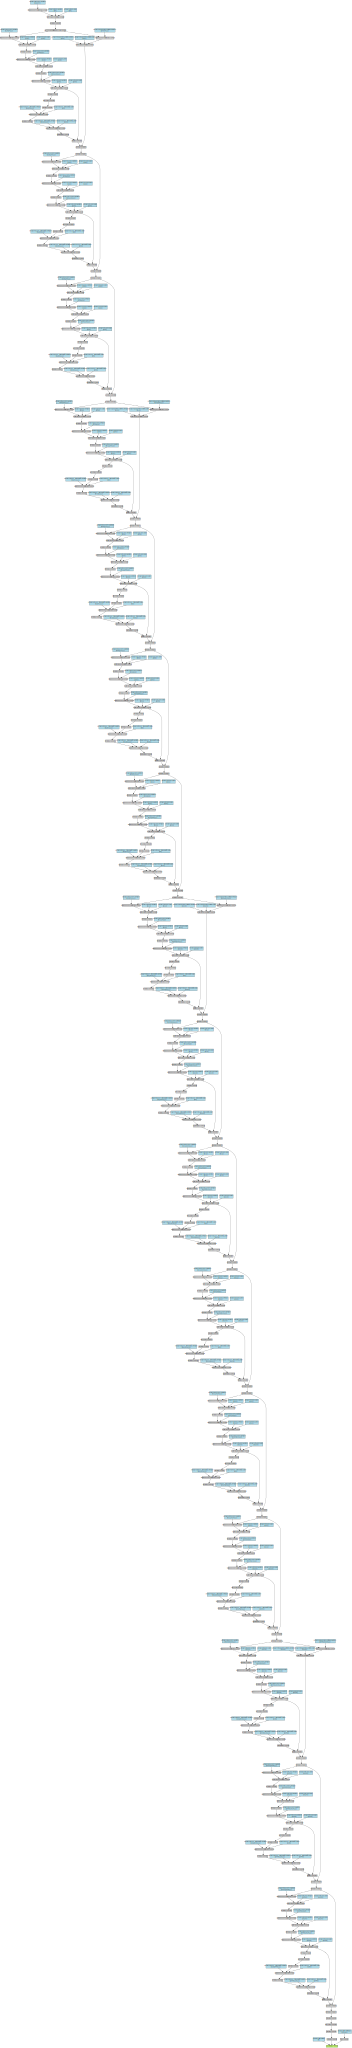

In [43]:
output = model(torch.rand(1,3,512,512))
make_dot(output, params=dict(model.named_parameters()))

### Model 2

In [44]:
#Issue is in this model
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.arch = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        #self.arch.load_state_dict(torch.load("C:/Users/tushar.sharma/Desktop/SIIM-Kaggle/resnet18-5c106cde.pth"))
        self.arch.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.arch.last_linear = nn.Linear(512, 1)
    
    def forward(self, image):
        output = self.arch(image)
        return output

In [45]:
model = ResNet18()
summary(model, torch.rand(1,3,512,512))

--------------------------------------------------------------------------------
        Layer (type)               Output Shape          Params    FLOPs(M+A) #
            Conv2d-1          [1, 64, 256, 256]            9408      1228931072
       BatchNorm2d-2          [1, 64, 256, 256]             256         8388608
              ReLU-3          [1, 64, 256, 256]               0               0
         MaxPool2d-4          [1, 64, 128, 128]               0               0
            Conv2d-5          [1, 64, 128, 128]           36864      1206910976
       BatchNorm2d-6          [1, 64, 128, 128]             256         2097152
              ReLU-7          [1, 64, 128, 128]               0               0
            Conv2d-8          [1, 64, 128, 128]           36864      1206910976
       BatchNorm2d-9          [1, 64, 128, 128]             256         2097152
             ReLU-10          [1, 64, 128, 128]               0               0
       BasicBlock-11          [1, 64, 1

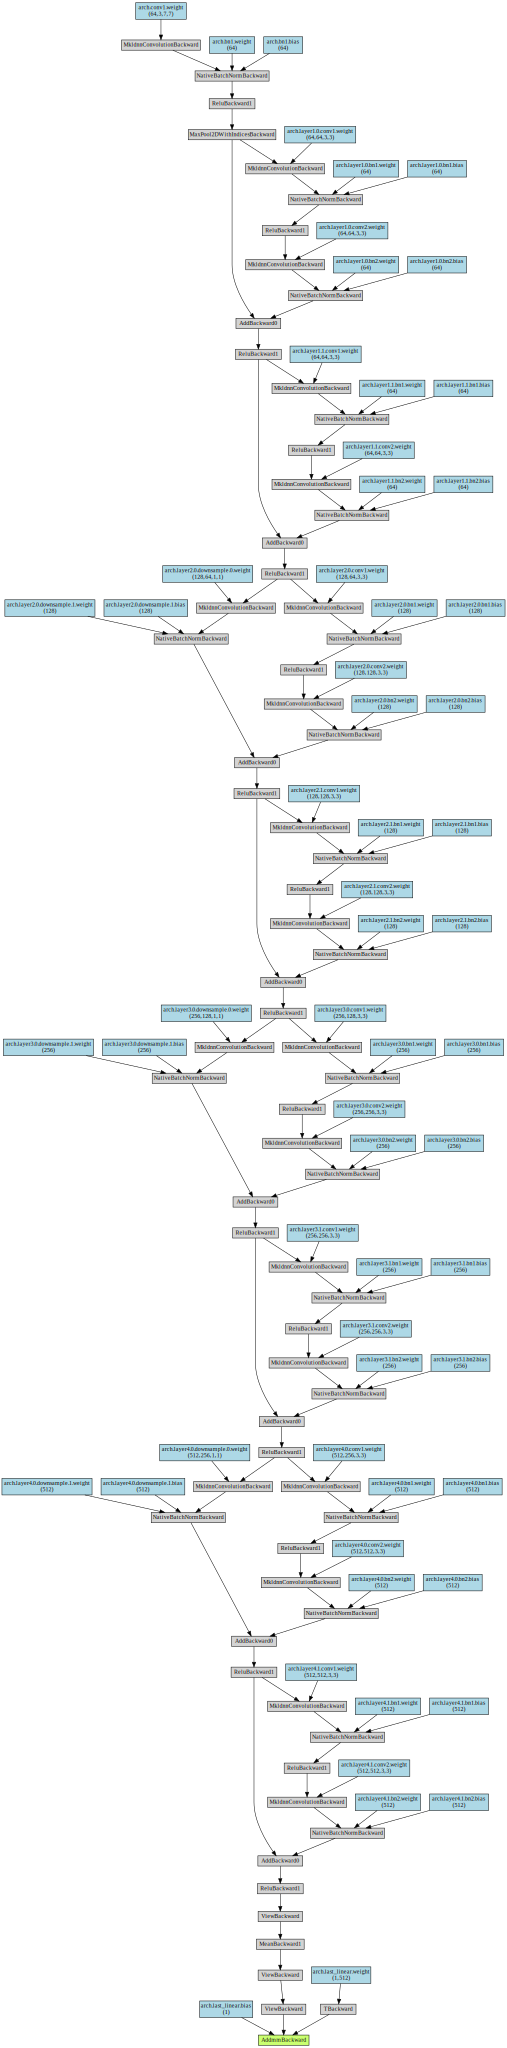

In [46]:
output = model(torch.rand(1,3,512,512))
make_dot(output, params=dict(model.named_parameters()))

In [32]:
print('Garbage collection in progress..')
gc.collect()

Garbage collection in progress..


118

### Image DataLoader

In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, imfolder:str, train=bool, transforms=None):
        self.df = dataframe
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return self.df.__len__()
    
    def __getitem__(self, index):
        image_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        image = cv2.imread(image_path)
        image = transforms.ToPILImage()(image)

        if self.transforms:
            image= self.transforms(image)
        
        if self.train:
            label = self.df.iloc[index]['target']
            return image, label
        else:
            return image

### Simple Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

### Average Meter Metric

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Training Variables

In [ ]:
device = "cuda"
epochs = 5
train_bs = 256

### Training

In [ ]:
train = MelanomaDataset(train_df, 
                        imfolder='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/', 
                        train=True, 
                        transforms=train_transform)
train_loader = DataLoader(dataset=train, batch_size=train_bs, shuffle=True, num_workers=2)

model = ResNet18()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,threshold=0.001, mode="max")
criterion = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    start_time = time.time()
    model.train()    
    losses = AverageMeter()
    epoch_loss = 0.
    correct = 0
    optimizer.zero_grad()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    for idx, (imgs, labels) in enumerate(tk):
        imgs_train = torch.tensor(imgs, device=device, dtype=torch.float32)
        labels_train = torch.tensor(labels, device=device, dtype=torch.float32)
        
        optimizer.zero_grad() 
        output_train = model(imgs_train)
        loss = criterion(output_train.squeeze(), labels_train)
        loss.backward()
        optimizer.step() 
        
        pred = torch.round(torch.sigmoid(output_train))  
        correct += (pred.cpu() == labels_train.cpu().unsqueeze(1)).sum().item()
        epoch_loss += loss.item()
        
        losses.update(loss.item(), imgs.size(0))
        tk.set_postfix(loss=losses.avg)
        
    train_acc = correct / len(train_idx)
    print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc,  
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
    scheduler.step(auc)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


 12%|█▏        | 16/130 [13:59<1:24:37, 44.54s/it, loss=0.609]